In [262]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector

## 1. Генерация данных

In [197]:
result_df = pd.DataFrame(columns=['способ выбора признаков', 'количество признаков', 'средняя точность модели'])
x_data_generated, y_data_generated = make_classification(scale=1, random_state=42)

generated_df = pd.concat([pd.DataFrame(x_data_generated), pd.DataFrame(y_data_generated)], axis=1)

## 2. Функция для нахождения средней точности

In [198]:
def get_mean_score(X, y, selection_method=''):
    mean_score = cross_val_score(
            LogisticRegression(), 
            X, 
            y, 
            scoring='accuracy'
        ).mean()
    
    data = {
        'способ выбора признаков': [selection_method], 
        'количество признаков': [X.shape[1]], 
        'средняя точность модели': [mean_score]
    }
    return pd.DataFrame(data=data)

## 3. Точность модели на обычном пространстве признаков

In [199]:
result_df = pd.concat([result_df, get_mean_score(x_data_generated, y_data_generated, selection_method='Nothing')])

## 4. Отсеиваем признаки на основе матрицы корреляций

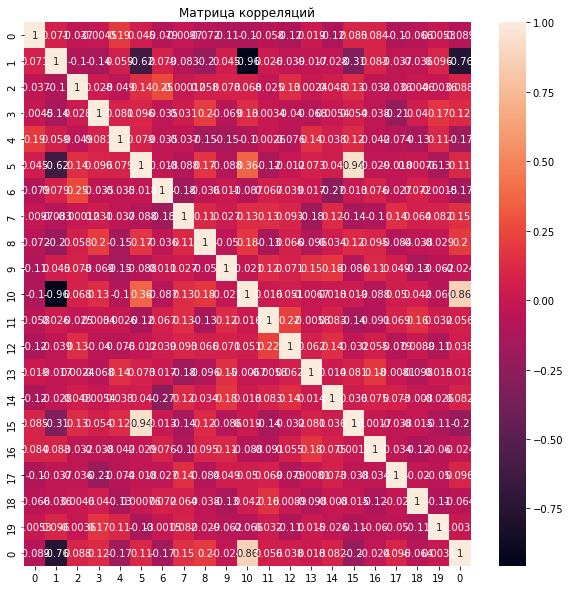

In [200]:
plt.figure(figsize=(10, 10))
plt.title('Матрица корреляций')
sns.heatmap(
    generated_df.corr(), 
    annot=True
)
plt.show()

### 4.1 Точность модели на признаках взятых с помощью матрицы корреляций

In [201]:
selected_features = [0, 1, 5, 10, 15]

X = np.array(generated_df[selected_features].iloc[:, 2:])
y = np.array(generated_df[selected_features].iloc[:, 1:2])

result_df = pd.concat([result_df, get_mean_score(X, y.ravel(order='C'), 'corr_matix')])

## 5. Отсеиваем признаки на основе дисперсии

In [282]:
X = np.array(VarianceThreshold(threshold=1.2).fit_transform(x_data_generated))
y = np.array(y_data_generated).ravel(order='C')

result_df = pd.concat([result_df, get_mean_score(X, y, 'VarianceThreshold')])

## 6. Отбор признаков на основе дисперсионного анализа

In [205]:
X_selected = SelectKBest(f_classif, k=5).fit_transform(x_data_generated, y_data_generated)

In [206]:
result_df = pd.concat([result_df, get_mean_score(X_selected, y_data_generated, 'ANOVA')])

## 7. Отбор признаков с использованием логистической регрессии

In [207]:
selected = SelectFromModel(
        estimator=LogisticRegression(
                penalty='l1', 
                solver='saga',
                max_iter=1000
        )
    ).fit(x_data_generated, y_data_generated)

In [208]:
result_df = pd.concat([result_df, get_mean_score(selected.transform(x_data_generated), y_data_generated, 'LogReg')])

## 8. Отбор признаков с помощью случайного леса

In [214]:
random_forest_model = RandomForestClassifier().fit(x_data_generated, y_data_generated)

(0.0, 20.0)

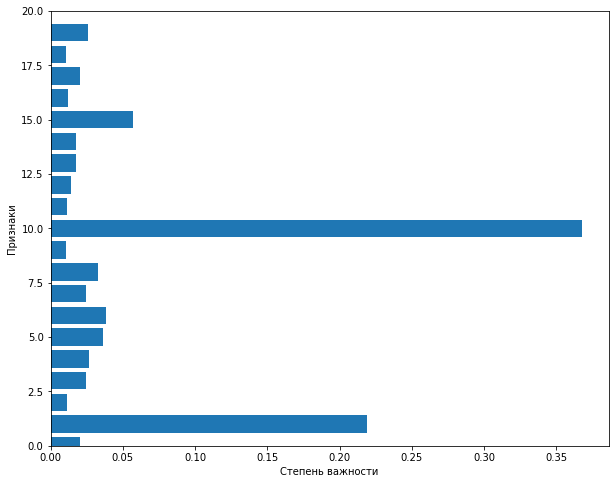

In [237]:
plt.figure(figsize=(10, 8))
plt.barh(
    generated_df.columns[:-1],
    random_forest_model.feature_importances_
)
plt.ylabel('Признаки')
plt.xlabel('Степень важности')
plt.ylim([0, 20])

In [250]:
selected_features = [1, 5, 6, 10, 16]

X = generated_df[selected_features]
y = generated_df[0].iloc[:, 1:]

result_df = pd.concat([result_df, get_mean_score(X, np.array(y).ravel(order='C'), 'RandomForest')])

In [251]:
result_df

,способ выбора признаков,количество признаков,средняя точность модели
0,Nothing,20,0.98
0,corr_matix,4,0.99
0,ANOVA,5,0.98
0,LogReg,9,0.98
0,RandomForest,5,0.98


## 9. Перебор признаков

In [256]:
sfs = SequentialFeatureSelector(
        estimator=LogisticRegression(max_iter=1000),
        n_features_to_select='auto'
    ).fit(x_data_generated, y_data_generated)

In [260]:
result_df = pd.concat([result_df, get_mean_score(sfs.transform(x_data_generated), y_data_generated, 'SFS')])

## Выводы

In [283]:
result_df

,способ выбора признаков,количество признаков,средняя точность модели
0,Nothing,20,0.98
0,corr_matix,4,0.99
0,ANOVA,5,0.98
0,LogReg,9,0.98
0,RandomForest,5,0.98
0,SFS,10,1.00
0,VarianceThreshold,6,0.99


В результате выделить то, что большинство моделей показали одинаковый результат, но SFS например подобрала такие признаки, что модель переобучилась.

И лучших методов в данной задаче я бы выделил VarianceThreshold и отбор признаков по матрице корреляций.